This is a neural network based on the modified U-Net architecture found in the DeepHarmony paper (as pictured below). In addition, it features batch normalization layers integrated within the network and a compound loss function made up of MS-SSIM and L1. 


Importing necessary modules

In [17]:
import os
from torch import optim, nn
import torch
from torch.utils.data import DataLoader, Dataset
# from Preprocessing import Preprocessing
import pytorch_lightning as pl
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from mriqc.qc import anatomical

In [18]:
scan = nib.load("./data/original/scanner1_sub-CC110069_T1w.nii")
scan_array = np.array(scan.dataobj)
scan_tensor = torch.tensor(scan_array, dtype=torch.float32)

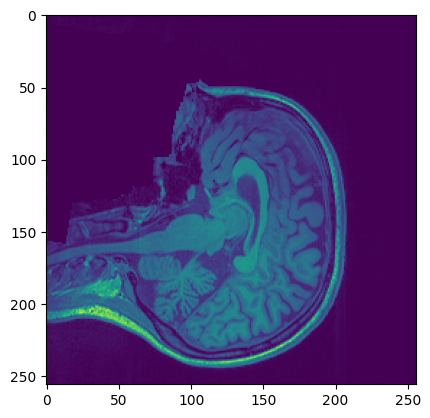

In [24]:
slice = scan_tensor[ :, :, 100]
plt.imshow(slice)

In [ ]:
s = {"a": "d", "b": "c"}
s["a"]

In [11]:
anatomical.snr()

torch.Size([256, 192])


Definition of the Network Class, including loss function definition and convolution definitions

In [4]:
# Model Class
class Unet(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # hyperparameters


        # definition of neural network (see accompanying picture of network for specific numbering)
        self.o1 = self.convolution(1, 16, 16)
        self.o2 = self.down_convolution(16, 16, 16)
        self.o3 = self.convolution(16, 32, 32)
        self.o4 = self.down_convolution(32, 32, 32)
        self.o5 = self.convolution(32, 64, 64)
        self.o6 = self.down_convolution(64, 64, 64)
        self.o7 = self.convolution(64, 128, 128)
        self.o8 = self.down_convolution(128, 128, 128)
        self.o9 = self.convolution(128, 256, 256)
        self.o10 = self.up_convolution(256, 256, 256)
        self.o12 = self.convolution(256, 128, 128)
        self.o13 = self.up_convolution(128, 128, 128)
        self.o15 = self.convolution(128, 64, 64)
        self.o16 = self.up_convolution(64, 64, 64)
        self.o18 = self.convolution(64, 32, 32)
        self.o19 = self.up_convolution(32, 32, 32)
        self.o21 = self.convolution(32, 16, 16)
        self.o23 = self.final_convolution(16, 1)
    
    # forward pass
    def forward(self, image):

        # left
        x1 = self.o1(image)

        x2 = self.o2(x1)
        
        x3 = self.o3(x2)
        
        x4 = self.o4(x3)
        
        x5 = self.o5(x4)
        
        x6 = self.o6(x5)
        
        x7 = self.o7(x6)
        
        x8 = self.o8(x7)
        
        x9 = self.o9(x8)
        

        # right
        x10 = self.o10(x9)
        
        y10 = self.crop_tensor(x10, x7)
        x11 = torch.cat([x10, y10], 1)
        
        x12 = self.o12(x11)
        
        x13 = self.o13(x12)

        y13 = self.crop_tensor(x13, x5)
        x14 = torch.cat([x13, y13], 1)

        x15 = self.o15(x14)

        x16 = self.o16(x15)

        y16 = self.crop_tensor(x16, x3)
        x17 = torch.cat([x16, y16], 1)

        x18 = self.o18(x17)

        x19 = self.o19(x18)

        y19 = self.crop_tensor(x19, x1)
        x20 = torch.cat([x19, y19], 1)

        x21 = self.o21(x20)

        x22 = torch.cat([x21, image], 1)

        x23 = self.o23(x22)

        return x23
    
    def convolution(self, in_c, out_c, num_features):
        run = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features)
        )
        return run
    
    def down_convolution(self, in_c, out_c, num_features):
        run = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(num_features)
        )
        return run

    def up_convolution(self, in_c, out_c, num_features):
        run = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 0.5),
            nn.ReLU(),
            nn.BatchNorm2d(num_features),
        )
        return run

    def final_convolution(self, in_c, out_c):
        run = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1),
            nn.ReLU()
        )
        return run

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

Importing Data, running preprocessing programs, and Splitting into training and validation

In [5]:
preprocessing = Preprocessing("./data/modified/", "./data/preprocessed/")

class MRIDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: preprocessing.input_folder, batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.training = []
        self.testing = []
        self.validation = []

    def setup(self, stage: str):
        # set up training, testing, validation split

        for i in range(179):
            self.training.append(self.input_files[i])

        for i in range(179, 223):
            self.testing.append(self.input_files[i])

        for i in range (223, 267):
            self.validation.append(self.input_files[i]) 


    def train_dataloader(self):
        return DataLoader(self.training, batch_size = self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.testing, batch_size = self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.validation, batch_size = self.batch_size)

    def configure_optimizers(self):
        opt = optim.Adam(self.parameters(), lr = self.hrparams.lr)